                                   DM Assignment2

In [54]:
import os

directory = os.getcwd()
images = r'cropped_images'

specific_folders  = ['Maltese_dog','Australian_terrier','Rottweiler','Weimaraner']

In [55]:
img=[]
hist=[]
breed=[]

class_labels = {'n02085936-Maltese_dog':0,'n02096294-Australian_terrier':1,'n02106550-Rottweiler':2,'n02092339-Weimaraner':3}

for folder in os.listdir(images):
    path = os.path.join(images, folder)
    if os.path.isdir(path):
        Images = os.listdir(path) 
        crop_images = [image for image in Images if image.lower().endswith(('.jpg'))]
        for image in crop_images:
            src_path = os.path.join(path, image)
            img.append(src_path)
            breed.append(class_labels[folder])

import numpy as np
from skimage import filters
from skimage import data, exposure, img_as_float,color
def angle(dx, dy):
 """Calculate the angles between horizontal and vertical operators."""
 return np.mod(np.arctan2(dy, dx), np.pi)

from skimage import filters
from skimage import io
for image in img:
    dog_img   = io.imread(image)
    dog_img=color.rgb2gray(dog_img)
    angle_sobel = angle(filters.sobel_h(dog_img),filters.sobel_v(dog_img))
    Hist,_=exposure.histogram(angle_sobel, nbins=36)
    hist.append(Hist)


hist=np.array(hist)
breed=np.array(breed)

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(hist, breed, test_size=0.2,stratify=breed, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [57]:
import warnings 
warnings.filterwarnings("ignore")

In [58]:
K = [1,3,5,7,10,20]

### standard and stratified 5 fold validation

In [59]:
from sklearn.model_selection import StratifiedKFold , cross_val_score,KFold
from sklearn.metrics import accuracy_score, f1_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier



def cross_validation(method):
    t_errors,v_errors=[],[]
    for k in K:
        model = KNeighborsClassifier(n_neighbors=k)
        traine,val=[],[]
        for train, test in method.split(X_train_scaled, y_train):
            xtrain, xval = X_train_scaled[train], X_train_scaled[test]
            ytrain, yval = y_train[train], y_train[test]
            model.fit(xtrain, ytrain)
            train_pred = model.predict(xtrain)
            val_pred = model.predict(xval)
            train_accuracy = accuracy_score(ytrain, train_pred)
            val_accuracy = accuracy_score(yval, val_pred)
            traine.append(1-train_accuracy)
            val.append(1-val_accuracy)
        t_errors.append(np.mean(traine))
        v_errors.append(np.mean(val))
    return t_errors,v_errors
            

In [60]:
standardtrainingerrors,standardvalidationerrors=cross_validation(KFold(n_splits=5))
stratifiedtrainingerrors,stratifiedvalidationerrors=cross_validation(StratifiedKFold(n_splits=5))


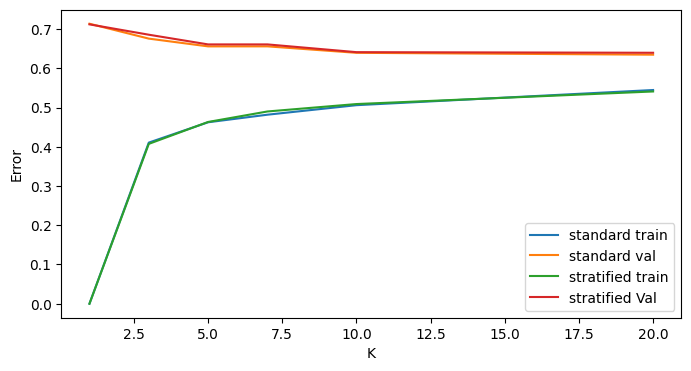

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(K, standardtrainingerrors, label='standard train')
plt.plot(K, standardvalidationerrors, label='standard val')
plt.plot(K, stratifiedtrainingerrors, label='stratified train')
plt.plot(K, stratifiedvalidationerrors, label='stratified Val')
plt.xlabel('K')
plt.ylabel('Error')
plt.legend()
plt.show()

the lowest mean error for standard Train    at k=1 ,
                        stratified Train    at k=1 ,
                     standard val    at k=20,
                        stratified val  at k=20

the model complexity : Less         when k = 1,
                       Intermidiate when 3,5,7,10 and
                       high         when= 20
 
we see our model overfits at 1 resulting in 0 error and underfits at 20 with vast spread neighbors 

In [63]:
### Testing error at least mean error for stratified which is 20

model = KNeighborsClassifier(n_neighbors = 20)
model.fit(X_train_scaled, y_train)
pred = model.predict(X_test_scaled)
print("Test Error at k= 20 :" +str(1-(accuracy_score(y_test,pred))))


Test Error at k= 20 :0.7236842105263157


In [64]:
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier



In [70]:
s=StratifiedKFold(n_splits=5)
def model_comparision(model):
    original,predict,cm,val_accuracy=[],[],[],[]
    for train, test in s.split(X_train_scaled, y_train):
        xtrain, xval = X_train_scaled[train], X_train_scaled[test]
        ytrain, yval = y_train[train], y_train[test]
        
        model.fit(xtrain, ytrain)
        pred= model.predict(xval)
        original.extend(yval)
        predict.extend(pred)
      
        val_acc = accuracy_score(yval, pred)
        val_accuracy.append(val_acc)
        
    print("mean vali accuracy: "+str(np.mean(val_accuracy)))
    
    test_acc = accuracy_score(y_test, model.predict(X_test_scaled))
    print("test accuracy : "+str(test_acc))

    f1score = f1_score(y_test, model.predict(X_test_scaled), average='weighted')
    print("f1 score : "+str(f1score))
    
    
    cm.append(confusion_matrix(y_test, model.predict(X_test_scaled)))
    cm_display = ConfusionMatrixDisplay(confusion_matrix = sum(cm)/len(cm), display_labels =specific_folders )
    cm_display.plot(xticks_rotation=45)
    plt.show()


In [71]:
#neural network

mean vali accuracy: 0.3452784175585964
test accuracy : 0.3223684210526316
f1 score : 0.314530050004593


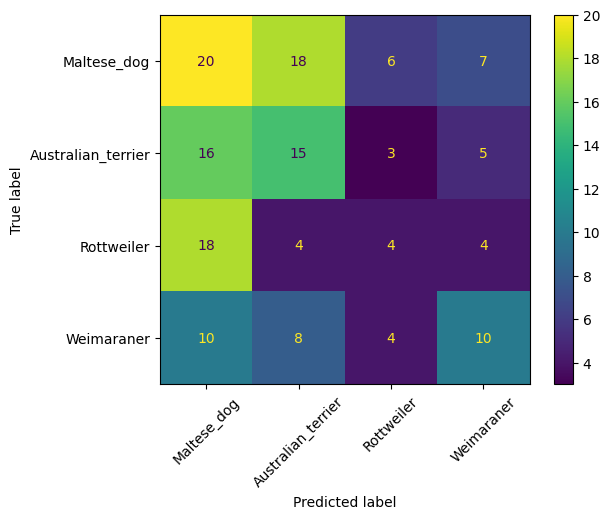

In [72]:
model_comparision(MLPClassifier(hidden_layer_sizes=(10,10,10)))


mean vali accuracy: 0.3601138057173825
test accuracy : 0.3355263157894737
f1 score : 0.32199155384393713


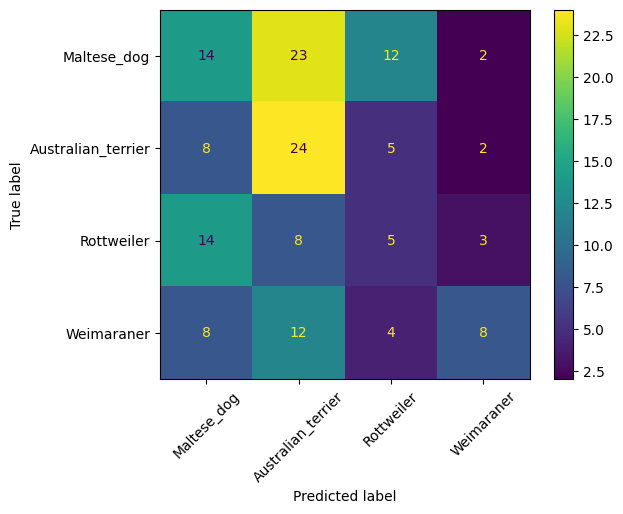

In [73]:
#naive bayes

model_comparision(GaussianNB())


mean vali accuracy: 0.3026012735401707
test accuracy : 0.3026315789473684
f1 score : 0.29613499219877454


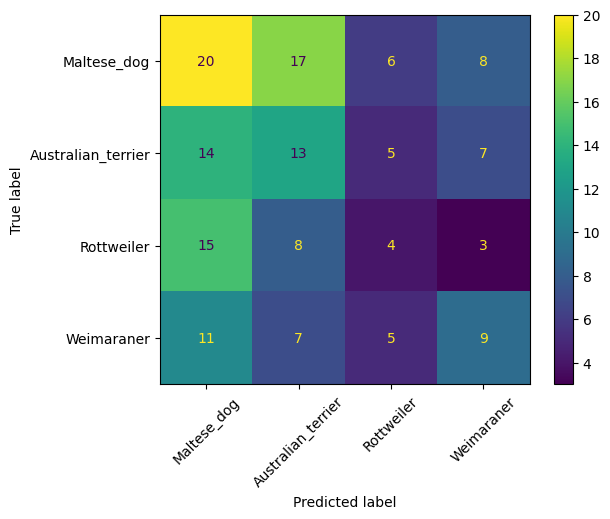

In [74]:
# Adaboost

model_comparision(AdaBoostClassifier())

Referencelinks:        
                https://scikit-image.org/docs/stable/api/skimage.exposure.html  
                https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html
                